In [5]:
# Append web folder to system path
import sys
sys.path.append('../web')

In [6]:
from db_config import Base
from Database import Station, Availability, Weather
from sqlalchemy import create_engine, func, Column, String, Integer, Double, Boolean
from sqlalchemy.orm import sessionmaker
import json
import sys

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [8]:
# Get the db_info
with open('../dbinfo.json') as f:
    db_info = json.load(f)


USER = db_info['dbConnection']['USER']
PASSWORD = db_info['dbConnection']['PASSWORD']
URI = db_info['dbConnection']['URI']
PORT = db_info['dbConnection']['PORT']
DB = db_info['dbConnection']['DB']

# Create a new session
engine = create_engine(
    'mysql+pymysql://{}:{}@localhost:{}/{}'.format(USER, PASSWORD, PORT, DB), echo=True)
Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()
print("connected")


2024-04-18 22:31:47,863 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-04-18 22:31:47,865 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-18 22:31:47,926 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-04-18 22:31:47,927 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-18 22:31:47,958 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-04-18 22:31:47,959 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-18 22:31:48,021 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-18 22:31:48,022 INFO sqlalchemy.engine.Engine DESCRIBE `db_on_your_bike`.`stations`
2024-04-18 22:31:48,022 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-18 22:31:48,056 INFO sqlalchemy.engine.Engine DESCRIBE `db_on_your_bike`.`availability`
2024-04-18 22:31:48,056 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-18 22:31:48,090 INFO sqlalchemy.engine.Engine DESCRIBE `db_on_your_bike`.`weather`
2024-04-18 22:31:48,090 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-18 22:31:4

In [9]:
weather = session.query(Weather).all()

for row in weather:
    print(row.time_updated, row.type, row.temperature, row.humidity, row.type)


2024-04-18 22:31:48,234 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-18 22:31:48,241 INFO sqlalchemy.engine.Engine SELECT weather.time_updated AS weather_time_updated, weather.type AS weather_type, weather.description AS weather_description, weather.temperature AS weather_temperature, weather.feels_like AS weather_feels_like, weather.min_temp AS weather_min_temp, weather.max_temp AS weather_max_temp, weather.humidity AS weather_humidity, weather.wind_speed AS weather_wind_speed, weather.visibility AS weather_visibility, weather.clouds AS weather_clouds, weather.sunrise AS weather_sunrise, weather.sunset AS weather_sunset 
FROM weather
2024-04-18 22:31:48,242 INFO sqlalchemy.engine.Engine [generated in 0.00165s] {}
2024-02-20 16:05:05 Clouds 11.91 81 Clouds
2024-02-20 16:10:05 Clouds 11.96 80 Clouds
2024-02-20 16:15:05 Clouds 11.83 81 Clouds
2024-02-20 16:20:05 Clouds 11.96 80 Clouds
2024-02-20 16:25:05 Clouds 11.83 81 Clouds
2024-02-20 16:30:06 Clouds 11.67 79 Clouds
2024-02-

In [10]:
bike_availability = session.query(Availability).all()


2024-04-18 22:31:48,980 INFO sqlalchemy.engine.Engine SELECT availability.station_id AS availability_station_id, availability.time_updated AS availability_time_updated, availability.bike_stands AS availability_bike_stands, availability.available_bikes AS availability_available_bikes, availability.available_bike_stands AS availability_available_bike_stands, availability.status AS availability_status 
FROM availability
2024-04-18 22:31:48,981 INFO sqlalchemy.engine.Engine [generated in 0.00103s] {}


In [13]:
availability_df = pd.DataFrame([row.__dict__ for row in bike_availability])


In [12]:
availability_df.drop('_sa_instance_state', axis=1, inplace=True)
availability_df.to_csv('availability.csv')

In [13]:
availability_df = pd.read_csv('availability.csv')
availability_df['time_updated'] = pd.to_datetime(availability_df['time_updated'])
availability_df.head()

,Unnamed: 0,available_bikes,time_updated,status,available_bike_stands,bike_stands,station_id,bike_stands
0,0,2,2024-02-20 16:05:06,OPEN,29,31,1,31
1,1,1,2024-02-20 16:10:06,OPEN,30,31,1,31
2,2,1,2024-02-20 16:15:06,OPEN,30,31,1,31
3,3,4,2024-02-20 16:20:06,OPEN,26,31,1,31
4,4,4,2024-02-20 16:25:06,OPEN,26,31,1,31


In [14]:
availability_df.sort_values('time_updated', inplace=True)

In [15]:
weather_df = pd.DataFrame([row.__dict__ for row in weather])
weather_df.drop('_sa_instance_state', axis=1, inplace=True)
weather_df.sort_values('time_updated', inplace=True)
weather_df.head()

,description,time_updated,feels_like,max_temp,wind_speed,clouds,sunset,temperature,type,min_temp,humidity,visibility,sunrise
0,few clouds,2024-02-20 16:05:05,11.27,12.36,9.77,20,1708451020,11.91,Clouds,11.53,81,10000,1708414464
1,few clouds,2024-02-20 16:10:05,11.30,12.36,9.77,20,1708451020,11.96,Clouds,11.53,80,10000,1708414464
2,few clouds,2024-02-20 16:15:05,11.18,12.36,9.77,20,1708451020,11.83,Clouds,11.05,81,10000,1708414464
3,few clouds,2024-02-20 16:20:05,11.30,12.36,9.77,20,1708451020,11.96,Clouds,11.53,80,10000,1708414464
4,few clouds,2024-02-20 16:25:05,11.18,12.36,9.77,20,1708451020,11.83,Clouds,11.05,81,10000,1708414464


In [16]:
weather_df.to_csv('weather.csv')

In [17]:
availability_df.sort_values('time_updated', inplace=True)

In [18]:
weather_df = pd.DataFrame([row.__dict__ for row in weather])
weather_df.drop('_sa_instance_state', axis=1, inplace=True)
weather_df.sort_values('time_updated', inplace=True)
weather_df.head()

,feels_like,description,time_updated,max_temp,wind_speed,clouds,sunset,type,temperature,min_temp,humidity,visibility,sunrise
0,11.27,few clouds,2024-02-20 16:05:05,12.36,9.77,20,1708451020,Clouds,11.91,11.53,81,10000,1708414464
1,11.30,few clouds,2024-02-20 16:10:05,12.36,9.77,20,1708451020,Clouds,11.96,11.53,80,10000,1708414464
2,11.18,few clouds,2024-02-20 16:15:05,12.36,9.77,20,1708451020,Clouds,11.83,11.05,81,10000,1708414464
3,11.30,few clouds,2024-02-20 16:20:05,12.36,9.77,20,1708451020,Clouds,11.96,11.53,80,10000,1708414464
4,11.18,few clouds,2024-02-20 16:25:05,12.36,9.77,20,1708451020,Clouds,11.83,11.05,81,10000,1708414464


In [18]:
weather_df.to_csv('weather.csv')

In [19]:
df = pd.merge_asof(availability_df, weather_df, on='time_updated')

In [20]:
df = df[['station_id', 'time_updated', 'available_bikes', 'available_bike_stands', 'temperature', 'wind_speed', 'humidity', 'type']]
df.head()

,station_id,time_updated,available_bikes,available_bike_stands,temperature,wind_speed,humidity,type
0,1,2024-02-20 16:05:06,2,29,11.91,9.77,81,Clouds
1,91,2024-02-20 16:05:06,13,17,11.91,9.77,81,Clouds
2,90,2024-02-20 16:05:06,36,4,11.91,9.77,81,Clouds
3,7,2024-02-20 16:05:06,0,29,11.91,9.77,81,Clouds
4,89,2024-02-20 16:05:06,10,30,11.91,9.77,81,Clouds


In [19]:
df.dtypes

station_id                        int64
time_updated             datetime64[ns]
available_bikes                   int64
available_bike_stands             int64
temperature                     float64
wind_speed                      float64
humidity                          int64
type                             object
dtype: object

In [20]:
df.to_csv('weather_availability_joined.csv')

In [21]:
df = pd.read_csv('weather_availability_joined.csv')
# Convert station_id to int64
df['station_id'] = df['station_id'].astype('int64')

# Convert time_updated to datetime64
df['time_updated'] = pd.to_datetime(df['time_updated'])

# Convert available_bikes, available_bike_stands, and humidity to int64
df['available_bikes'] = df['available_bikes'].astype('int64')
df['available_bike_stands'] = df['available_bike_stands'].astype('int64')
df['humidity'] = df['humidity'].astype('int64')

# Convert temperature and wind_speed to float64
df['temperature'] = df['temperature'].astype('float64')
df['wind_speed'] = df['wind_speed'].astype('float64')


In [22]:
# One hot encode day of the week
df['weekday'] = df['time_updated'].dt.day_name()
df['hour'] = df['time_updated'].dt.hour
df['day'] = df['time_updated'].dt.day
one_hot_encoded_days = pd.get_dummies(df['weekday'])
df['rain'] = df['type'] == 'Rain'

df = pd.concat([df, one_hot_encoded_days], axis=1)

df.drop('time_updated', axis = 1, inplace=True)
df.drop('weekday', axis = 1, inplace=True)
df.drop('Unnamed: 0', axis = 1, inplace=True)
df.drop('type', axis=1, inplace=True)


df.head()

,station_id,available_bikes,available_bike_stands,temperature,wind_speed,humidity,hour,day,rain,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,2,29,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
1,91,13,17,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
2,90,36,4,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
3,7,0,29,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
4,89,10,30,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False


In [23]:
print(one_hot_encoded_days.columns)

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')


In [24]:
df.head()

,station_id,available_bikes,available_bike_stands,temperature,wind_speed,humidity,hour,day,rain,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,2,29,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
1,91,13,17,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
2,90,36,4,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
3,7,0,29,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
4,89,10,30,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False


In [25]:
from sklearn.metrics import r2_score

In [26]:
unique_station_ids = df['station_id'].unique()

r2_list = []

for station_id in unique_station_ids:

    temp_df = df[( df['station_id'] == station_id)]
    temp_train_df = temp_df.drop(['station_id', 'available_bikes', 'available_bike_stands'], axis=1)

    x_train, x_test, y_train, y_test = train_test_split(temp_train_df, temp_df['available_bike_stands'], test_size = 0.3, random_state=23)

    poly = PolynomialFeatures(degree=3, include_bias=False)
    poly_features = poly.fit_transform(x_train)

    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y_train)

    with open(f'station_{station_id}.pkl', 'wb') as file:
        # Serialize and save the model to the file
        pickle.dump(poly_reg_model, file)

    poly_test_features = poly.fit_transform(x_test)
    y_pred_test = poly_reg_model.predict(poly_test_features)
    r2 = r2_score(y_test, y_pred_test)
    r2_list.append(r2)

temp_df.columns

Index(['station_id', 'available_bikes', 'available_bike_stands', 'temperature',
       'wind_speed', 'humidity', 'hour', 'day', 'rain', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

In [36]:
temp_train_df.columns

Index(['temperature', 'wind_speed', 'humidity', 'hour', 'day', 'rain',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

In [37]:
temp_train_df.dtypes

temperature    float64
wind_speed     float64
humidity         int64
hour             int32
day              int32
rain              bool
Friday            bool
Monday            bool
Saturday          bool
Sunday            bool
Thursday          bool
Tuesday           bool
Wednesday         bool
dtype: object

In [27]:
mean = sum(r2_list) / len(r2_list)
print(mean)

0.7119871657876184


In [28]:
temp_train_df.columns

Index(['temperature', 'wind_speed', 'humidity', 'hour', 'day', 'rain',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

In [29]:
y_pred_train = poly_reg_model.predict(poly_features)

poly_test_features = poly.fit_transform(x_test)
y_pred_test = poly_reg_model.predict(poly_test_features)

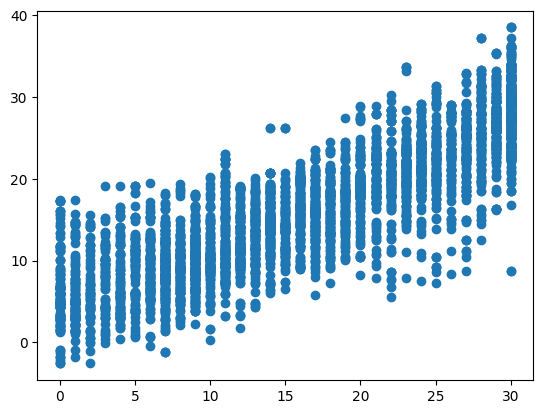

In [30]:
plt.scatter(y_test, y_pred_test)

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
r2 = r2_score(y_test, y_pred_test)
print(r2)

0.7396825847700226


In [33]:
with open('station_1.pkl', 'wb') as file:
    # Serialize and save the model to the file
    pickle.dump(poly_reg_model, file)

In [34]:
with open('station_1.pkl', 'rb') as file:
    # Load the model from the file
    poly_reg_model = pickle.load(file)


poly_reg_model.predict(poly_features)

array([26.20762029, 18.75142921, 11.59203184, ..., 18.04191586,
       21.62875518,  5.4721654 ])

In [35]:
def get_stations(station_id):
    poly = PolynomialFeatures(degree=3, include_bias=False)
    with open(f'station_{station_id}.pkl', 'rb') as file:
        # Load the model from the file
        poly_reg_model = pickle.load(file)

    
    predictions = poly_reg_model.predict(poly_features)
    # row = session.query(Availability).filter_by(station_id=station_id)
    return predictions

get_stations(1)

array([26.20762029, 18.75142921, 11.59203184, ..., 18.04191586,
       21.62875518,  5.4721654 ])